In [1]:
from itertools import product
from typing import Callable

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats
from mlxtend.data import iris_data
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

Different approaches to constructing **confidence intervals**, as shown on the [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris) and a [decision tree classifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html).<br>
In this notebook, we will create confidence intervals for the accuracy of the classifier.<br>
Source: [Creating Confidence Intervals for Machine Learning Classifiers, *Sebastian Raschka*](https://sebastianraschka.com/blog/2022/confidence-intervals-for-ml.html?utm_campaign=Data_Elixir&utm_source=Data_Elixir_384#method-3--bootstrapping-the-test-set-predictions)

In [2]:
X, y = iris_data()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=42, stratify=y
)

clf = DecisionTreeClassifier(random_state=42)

In [3]:
results = []

# Normal Approximation Interval Based on a Test Set
This confidence interval is computed from a single training-test split. The equation for the confidence interval for the classifier accuracy on the test set is as follows:
$$ACC_{test}\pm z\sqrt{\frac{1}{n}ACC_{test}(1 - ACC_{test})}$$
where

* $z$ is the number of standard deviations that a value lies from the mean of a standard normal distribution;
* $n$ is the test set size.

In [4]:
confidence = 0.95
z_value = scipy.stats.norm.ppf((1 + confidence) / 2.0)
print(f"Z-value: {z_value}")

Z-value: 1.959963984540054


In [5]:
clf.fit(X_train, y_train)

acc_test = clf.score(X_test, y_test)
ci_length = z_value * np.sqrt((acc_test * (1 - acc_test)) / y_test.shape[0])

ci_lower = acc_test - ci_length
ci_upper = acc_test + ci_length

print(f"Lower 95% CI: {ci_lower}")
print(f"Upper 95% CI: {ci_upper}")

Lower 95% CI: 0.7971610354461997
Upper 95% CI: 0.9923126487643267


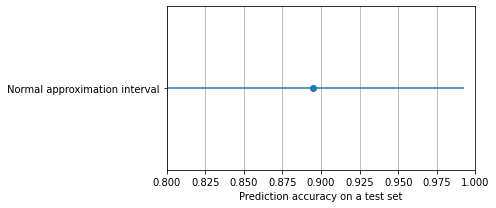

In [6]:
fig, ax = plt.subplots(figsize=(7, 3))

ax.errorbar(acc_test, 0, xerr=ci_length, fmt="o")

ax.set_xlim([0.8, 1.0])

ax.set_yticks(np.arange(1))
ax.set_yticklabels(["Normal approximation interval"])
ax.set_xlabel("Prediction accuracy on a test set")

plt.tight_layout()
plt.grid(axis="x")
plt.show()

In [7]:
results.append({
    "method": "Normal approximation",
    "acc_test": acc_test,
    "ci_lower": ci_lower,
    "ci_upper": ci_upper
})

# Bootstrapping Training Sets
**Bootstrapping** is a method of estimating the sampling distribution by taking multiple samples with replacement from a single random sample. The equation for the average classifier accuracy on bootstrapped data is as follows:
$$ACC_{bootavg}=\frac{1}{b}\sum_{j=1}^{b}ACC_{boot j}$$
where

* $b$ is the number of bootstrap rounds (usually recommended to be at least $200$);
* $ACC_{boot j}$ is the classifier accuracy computed at the $j$-th round.

## Data Preparation

In [8]:
rng = np.random.RandomState(seed=42)
idx = np.arange(y_train.shape[0])

bootstrap_train_accuracies = []
bootstrap_rounds = 200


for i in range(bootstrap_rounds):

    train_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    valid_idx = np.setdiff1d(idx, train_idx, assume_unique=False)

    boot_train_X, boot_train_y = X_train[train_idx], y_train[train_idx]
    boot_valid_X, boot_valid_y = X_train[valid_idx], y_train[valid_idx]

    clf.fit(boot_train_X, boot_train_y)
    acc = clf.score(boot_valid_X, boot_valid_y)
    bootstrap_train_accuracies.append(acc)

bootstrap_train_mean = np.mean(bootstrap_train_accuracies)

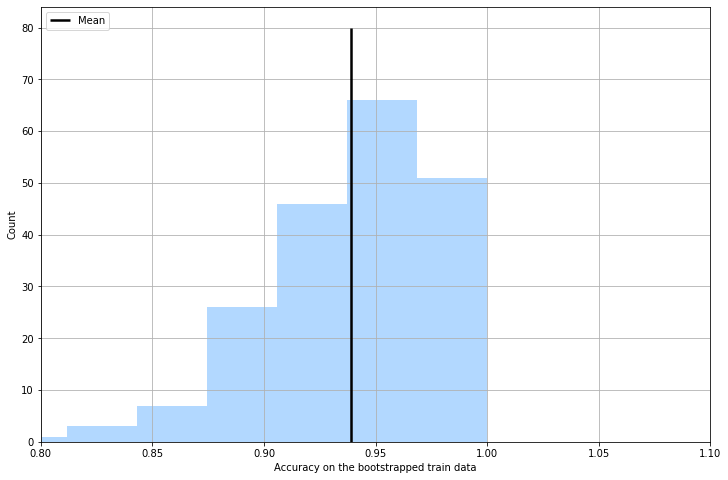

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))

ax.vlines(bootstrap_train_mean, [0], 80, lw=2.5, linestyle="-", label="Mean")

ax.hist(
    bootstrap_train_accuracies, bins=7,
    color="#0080ff", edgecolor="none", alpha=0.3
)

plt.xlabel('Accuracy on the bootstrapped train data')
plt.ylabel('Count')
plt.xlim([0.8, 1.1])

plt.legend(loc="upper left")
plt.grid()
plt.show()

## A *t* Confidence Interval from Bootstrap Samples
The equation for a $t$ confidence interval for a classifier accuracy from train bootstrap samples is as follows:
$$ACC_{test}=\pm t\times\sqrt{\frac{1}{b - 1}\sum_{j=1}^{b}\big(ACC_{boot j}-ACC_{bootavg}\big)^2}$$
where

* $t$ is [*t-statistic*](https://en.wikipedia.org/wiki/T-statistic);
* $b$ is the number of bootstrap rounds;
* $ACC_{boot j}$ is the classifier accuracy computed at the $j$-th round.

In [10]:
confidence = 0.95
t_value = scipy.stats.t.ppf((1 + confidence) / 2.0, df=bootstrap_rounds - 1)
print(f"t-value: {t_value}")

t-value: 1.971956544249395


In [11]:
se = 0.0

for acc in bootstrap_train_accuracies:
    se += (acc - bootstrap_train_mean) ** 2
se = np.sqrt((1.0 / (bootstrap_rounds - 1)) * se)

ci_length = t_value * se

ci_lower = bootstrap_train_mean - ci_length
ci_upper = bootstrap_train_mean + ci_length

print(f"Lower 95% CI: {ci_lower}")
print(f"Upper 95% CI: {ci_upper}")

Lower 95% CI: 0.866115852291848
Upper 95% CI: 1.0115869075458848


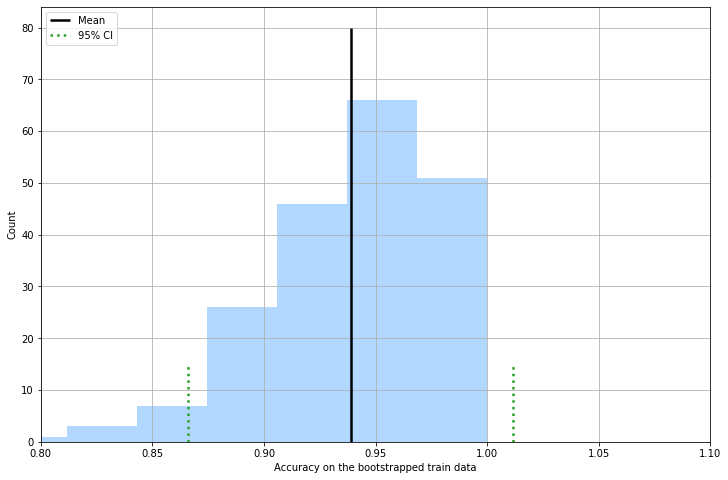

In [12]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.vlines(bootstrap_train_mean, [0], 80, lw=2.5, linestyle="-", label="Mean")

ax.vlines(
    ci_lower, [0], 15, lw=2.5, linestyle="dotted", label="95% CI", color="C2"
    )

ax.vlines(ci_upper, [0], 15, lw=2.5, linestyle="dotted", color="C2")

ax.hist(
    bootstrap_train_accuracies, bins=7,
    color="#0080ff", edgecolor="none", alpha=0.3
)

plt.xlabel('Accuracy on the bootstrapped train data')
plt.ylabel('Count')
plt.xlim([0.8, 1.1])

plt.legend(loc="upper left")

plt.grid()
plt.show()

In [13]:
results.append({
    "method": "Bootstrap, 1-sample CI",
    "acc_test": bootstrap_train_mean,
    "ci_lower": ci_lower,
    "ci_upper": ci_upper
})

## Bootstrap Confidence Intervals Using the Percentile Method
Here, the lower and upper classifier accuracy confidence bounds are picked as follows:

* $ACC_{lower}=\alpha_{1}$-th percentile of the $ACC_{boot}$ distribution;
* $ACC_{upper}=\alpha_{2}$-th percentile of the $ACC_{boot}$ distribution.

where $\alpha_{1}=\alpha$ and $\alpha_{2}=1 - \alpha$ and $\alpha$ is our degree of confidence to compute the $100\%\times(1 - 2\times\alpha)$ confidence interval.<br>
To compute a $95\%$ confidence interval, we pick $\alpha=0.025$ to obtain the $2.5$th and $97.5$th percentiles of the $b$ bootstrap samples distribution as our upper and lower confidence bounds.

In [14]:
ci_lower = np.percentile(bootstrap_train_accuracies, 2.5)
ci_upper = np.percentile(bootstrap_train_accuracies, 97.5)

print(f"Lower 95% CI: {ci_lower}")
print(f"Upper 95% CI: {ci_upper}")

Lower 95% CI: 0.8569099378881987
Upper 95% CI: 1.0


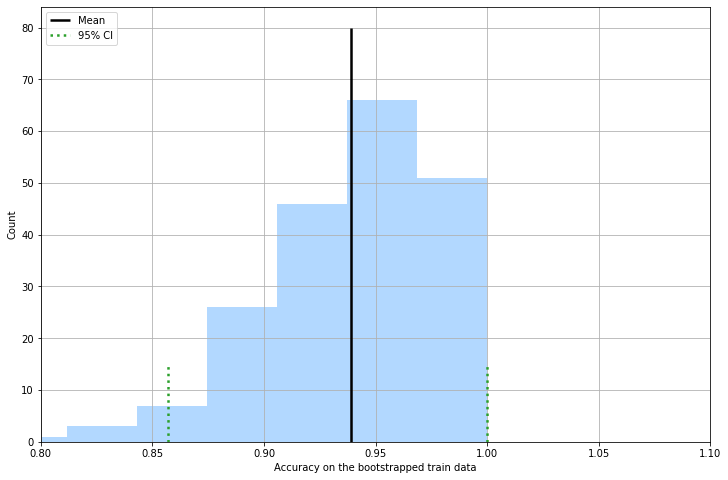

In [15]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.vlines(bootstrap_train_mean, [0], 80, lw=2.5, linestyle="-", label="Mean")

ax.vlines(
    ci_lower, [0], 15, lw=2.5, linestyle="dotted", label="95% CI", color="C2"
    )

ax.vlines(ci_upper, [0], 15, lw=2.5, linestyle="dotted", color="C2")

ax.hist(
    bootstrap_train_accuracies, bins=7,
    color="#0080ff", edgecolor="none", alpha=0.3
)

plt.legend(loc="upper left")

plt.xlabel('Accuracy on the bootstrapped train data')
plt.ylabel('Count')
plt.xlim([0.8, 1.1])

plt.grid()
plt.show()

In [16]:
results.append({
    "method": "Bootstrap, percentile",
    "acc_test": bootstrap_train_mean,
    "ci_lower": ci_lower,
    "ci_upper": ci_upper
})

## The .632 Bootstrap
Skipping over the technical details, the previously introduced out-of-bag bootstrap method has a slight pessimistic bias, which means that it reports a test accuracy that is slightly worse than the true generalization accuracy of the model. The [.632 bootstrap](https://www.tandfonline.com/doi/abs/10.1080/01621459.1983.10477973) aims to correct this pessimitic bias.

In [17]:
rng = np.random.RandomState(seed=42)
idx = np.arange(y_train.shape[0])

bootstrap_train_accuracies = []
bootstrap_rounds = 200
weight = 0.632

for i in range(bootstrap_rounds):

    train_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    valid_idx = np.setdiff1d(idx, train_idx, assume_unique=False)

    boot_train_X, boot_train_y = X_train[train_idx], y_train[train_idx]
    boot_valid_X, boot_valid_y = X_train[valid_idx], y_train[valid_idx]

    clf.fit(boot_train_X, boot_train_y)
    valid_acc = clf.score(boot_valid_X, boot_valid_y)
    # predict training accuracy on the whole training set
    # as ib the original .632 boostrap paper
    # in Eq (6.12) in
    #    "Estimating the Error Rate of a Prediction Rule: Improvement
    #     on Cross-Validation"
    #     by B. Efron, 1983, https://doi.org/10.2307/2288636
    train_acc = clf.score(X_train, y_train)

    acc = weight * train_acc + (1.0 - weight) * valid_acc

    bootstrap_train_accuracies.append(acc)

bootstrap_train_mean = np.mean(bootstrap_train_accuracies)
print(f"Bootstrap train mean: {bootstrap_train_mean}")

Bootstrap train mean: 0.9634748078101427


In [18]:
ci_lower = np.percentile(bootstrap_train_accuracies, 2.5)
ci_upper = np.percentile(bootstrap_train_accuracies, 97.5)

print(f"Lower 95% CI: {ci_lower}")
print(f"Upper 95% CI: {ci_upper}")

Lower 95% CI: 0.9078428571428572
Upper 95% CI: 1.0


In [19]:
results.append({
    "method": "Bootstrap, .632",
    "acc_test": bootstrap_train_mean,
    "ci_lower": ci_lower,
    "ci_upper": ci_upper
})

## The .632+ Bootstrap
The [.632+ Bootstrap](https://www.tandfonline.com/doi/abs/10.1080/01621459.1997.10474007) is an improvement over the bootstrap we implemented above. In a nutshell, the main difference is that the weighting terms are computed from the so-called no-information rate rather than being fixed.

In [20]:
def no_information_rate(
    targets: np.ndarray, predictions: np.ndarray,
    loss_fn: Callable[[np.ndarray, np.ndarray], float]
        ) -> float:
    """
    Compute the no-information rate for a given targets array,
    predictions array and loss function.

    Parameters:
        targets: np.ndarray
        predictions: np.ndarray
        loss_fn: Callable[[np.ndarray, np.ndarray], float]

    Returns:
        float
    """
    combinations = np.array(list(product(targets, predictions)))
    return loss_fn(combinations[:, 0], combinations[:, 1])

In [21]:
rng = np.random.RandomState(seed=42)
idx = np.arange(y_train.shape[0])

bootstrap_train_accuracies = []
bootstrap_rounds = 200
weight = 0.632


for i in range(bootstrap_rounds):

    train_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    valid_idx = np.setdiff1d(idx, train_idx, assume_unique=False)

    boot_train_X, boot_train_y = X_train[train_idx], y_train[train_idx]
    boot_valid_X, boot_valid_y = X_train[valid_idx], y_train[valid_idx]

    clf.fit(boot_train_X, boot_train_y)
    train_acc = clf.score(X_train, y_train)
    valid_acc = clf.score(boot_valid_X, boot_valid_y)

    gamma = no_information_rate(y, clf.predict(X), accuracy_score)
    R = (valid_acc - train_acc) / (gamma - train_acc)

    weight = 0.632 / (1 - 0.368 * R)

    acc = weight * train_acc + (1.0 - weight) * valid_acc

    bootstrap_train_accuracies.append(acc)

bootstrap_train_mean = np.mean(bootstrap_train_accuracies)
print(f"Bootstrap train mean: {bootstrap_train_mean}")

Bootstrap train mean: 0.9642738885781609


In [22]:
ci_lower = np.percentile(bootstrap_train_accuracies, 2.5)
ci_upper = np.percentile(bootstrap_train_accuracies, 97.5)

print(f"Lower 95% CI: {ci_lower}")
print(f"Upper 95% CI: {ci_upper}")

Lower 95% CI: 0.9104730522993049
Upper 95% CI: 1.0


In [23]:
results.append({
    "method": "Bootstrap, .632+",
    "acc_test": bootstrap_train_mean,
    "ci_lower": ci_lower,
    "ci_upper": ci_upper
})

# Bootstrapping the Test Set Predictions
Let’s look at another way we can construct confidence intervals involving bootstrapping, namely, bootstrapping the test set (one example of this method being used is in the article [Machine Learning for Scent: Learning Generalizable Perceptual Representations of Small Molecules](https://arxiv.org/abs/1910.10685)).

In [24]:
clf.fit(X_train, y_train)

predictions_test = clf.predict(X_test)
acc_test = np.mean(predictions_test == y_test)

rng = np.random.RandomState(seed=42)
idx = np.arange(y_test.shape[0])

test_accuracies = []

for i in range(200):
    pred_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    acc_test_boot = np.mean(predictions_test[pred_idx] == y_test[pred_idx])
    test_accuracies.append(acc_test_boot)

bootstrap_train_mean = np.mean(test_accuracies)
print(f"Bootstrap train mean: {bootstrap_train_mean}")

Bootstrap train mean: 0.897236842105263


In [25]:
ci_lower = np.percentile(test_accuracies, 2.5)
ci_upper = np.percentile(test_accuracies, 97.5)

print(f"Lower 95% CI: {ci_lower}")
print(f"Upper 95% CI: {ci_upper}")

Lower 95% CI: 0.8157894736842105
Upper 95% CI: 0.9736842105263158


In [26]:
results.append({
    "method": "Bootstrap test set",
    "acc_test": bootstrap_train_mean,
    "ci_lower": ci_lower,
    "ci_upper": ci_upper
})

# Confidence Intervals from Retraining Models with Different Random Seeds
Let's retrain our classifier with different random seeds and construct classifier accuracy confidence interval from the results. The formula for the average accuracy during these experiments is as follows:
$$\overline{ACC}_{test}\pm t\times\frac{\sqrt{\frac{\sum_j\big(ACC_{test j} - \overline{ACC}_{test}\big)^2}{r - 1}}}{\sqrt{r}}$$
where

* $t$ is [*t-statistic*](https://en.wikipedia.org/wiki/T-statistic);
* $r$ is the number of rounds (different random seeds used);
* $ACC_{test j}$ is the classifier accuracy computed at the $j$-th round.

In [27]:
test_accuracies = []
rounds = 5

for i in range(rounds):
    clf = DecisionTreeClassifier(random_state=i)
    clf.fit(X_train, y_train)
    acc = clf.score(X_test, y_test)
    test_accuracies.append(acc)

test_mean = np.mean(test_accuracies)
print(f"Test mean: {test_mean}")

Test mean: 0.9315789473684211


In [28]:
confidence = 0.95
t_value = scipy.stats.t.ppf((1 + confidence) / 2.0, df=rounds - 1)

sd = np.std(test_accuracies, ddof=1)
se = sd / np.sqrt(rounds)

ci_length = t_value * se

ci_lower = test_mean - ci_length
ci_upper = test_mean + ci_length

print(f"Lower 95% CI: {ci_lower}")
print(f"Upper 95% CI: {ci_upper}")

Lower 95% CI: 0.8943232953425717
Upper 95% CI: 0.9688345993942704


# Different Confidence Interval Methods Comparison

In [29]:
results_df = pd.DataFrame(results).set_index("method")

In [30]:
results_df.head()

,acc_test,ci_lower,ci_upper
method,,,
Normal approximation,0.894737,0.797161,0.992313
"Bootstrap, 1-sample CI",0.938851,0.866116,1.011587
"Bootstrap, percentile",0.938851,0.856910,1.000000
"Bootstrap, .632",0.963475,0.907843,1.000000
"Bootstrap, .632+",0.964274,0.910473,1.000000


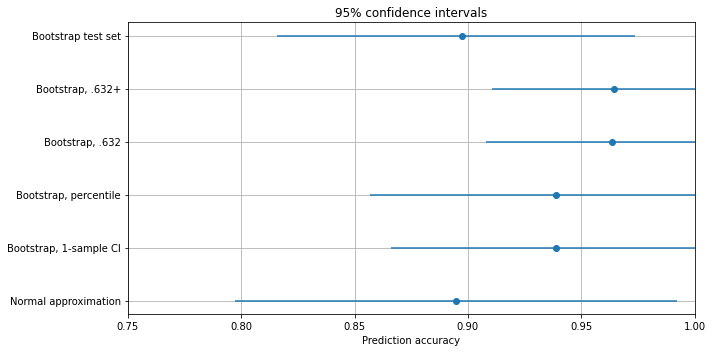

In [42]:
labels = np.array(results_df.index)

means, lower_error, upper_error = map(
    np.array,
    [results_df["acc_test"], results_df["ci_lower"], results_df["ci_upper"]]
    )

asymmetric_error = [means - lower_error, upper_error - means]

fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(means, np.arange(len(means)), xerr=asymmetric_error, fmt="o")
ax.set_xlim([0.75, 1.0])
ax.set_yticks(np.arange(len(means)))
ax.set_yticklabels(labels)
ax.set_xlabel("Prediction accuracy")
ax.set_title("95% confidence intervals")

plt.grid()
plt.tight_layout()
plt.show()

# Testing Different Confidence Interval Methods on a Synthetic Dataset
Let’s look at the results of a small simulation study to investigate how precise the different confidence interval methods are. Here, we are interested in seeing whether the true model accuracy (generalization accuracy) is actually contained in the confidence intervals.

We create a synthetic dataset consisting of 10 million and 2 thousand data points for classification. The first 1000 data points are used for training, the second 1000 data points are used for testing, and the remaining 10 000 000 data points represent the dataset we use to calculate the model’s true performance.

In [51]:
X, y = make_classification(
    n_samples=10_002_000,
    n_features=5,
    n_redundant=2,
    n_classes=2,
    n_clusters_per_class=1,
    random_state=42,
    flip_y=0.25,
)

X_train = X[:1_000]
y_train = y[:1_000]

X_test = X[1_000:2_000]
y_test = y[1_000:2_000]

X_huge_test = X[2_000:]
y_huge_test = y[2_000:]

In [52]:
results = []

In [53]:
clf = DecisionTreeClassifier(random_state=42, max_depth=3)
clf.fit(X_train, y_train)

acc_test_true = clf.score(X_huge_test, y_huge_test)
print(f"True accuracy of the classifier: {acc_test_true}")

True accuracy of the classifier: 0.8126501


In [54]:
confidence = 0.95
z_value = scipy.stats.norm.ppf((1 + confidence) / 2.0)

clf.fit(X_train, y_train)

acc_test = clf.score(X_test, y_test)
ci_length = z_value * np.sqrt((acc_test * (1 - acc_test)) / y_test.shape[0])

ci_lower = acc_test - ci_length
ci_upper = acc_test + ci_length

results.append({
    "method": "Normal approximation",
    "acc_test": acc_test,
    "ci_lower": ci_lower,
    "ci_upper": ci_upper
})

In [55]:
rng = np.random.RandomState(seed=42)
idx = np.arange(y_train.shape[0])

bootstrap_train_accuracies = []
bootstrap_rounds = 200

for i in range(bootstrap_rounds):
    train_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    valid_idx = np.setdiff1d(idx, train_idx, assume_unique=False)

    boot_train_X, boot_train_y = X_train[train_idx], y_train[train_idx]
    boot_valid_X, boot_valid_y = X_train[valid_idx], y_train[valid_idx]

    clf.fit(boot_train_X, boot_train_y)
    acc = clf.score(boot_valid_X, boot_valid_y)
    bootstrap_train_accuracies.append(acc)

bootstrap_train_mean = np.mean(bootstrap_train_accuracies)

confidence = 0.95
t_value = scipy.stats.t.ppf((1 + confidence) / 2.0, df=bootstrap_rounds - 1)


se = 0.0

for acc in bootstrap_train_accuracies:
    se += (acc - bootstrap_train_mean) ** 2

se = np.sqrt((1.0 / (bootstrap_rounds - 1)) * se)

ci_length = t_value * se

ci_lower = bootstrap_train_mean - ci_length
ci_upper = bootstrap_train_mean + ci_length

results.append({
    "method": "Bootstrap, 1-sample CI",
    "acc_test": bootstrap_train_mean,
    "ci_lower": ci_lower,
    "ci_upper": ci_upper
})

In [56]:
ci_lower = np.percentile(bootstrap_train_accuracies, 2.5)
ci_upper = np.percentile(bootstrap_train_accuracies, 97.5)

results.append({
    "method": "Bootstrap, percentile",
    "acc_test": bootstrap_train_mean,
    "ci_lower": ci_lower,
    "ci_upper": ci_upper
})

In [57]:
rng = np.random.RandomState(seed=42)
idx = np.arange(y_train.shape[0])

bootstrap_train_accuracies = []
bootstrap_rounds = 200
weight = 0.632

for i in range(bootstrap_rounds):
    train_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    valid_idx = np.setdiff1d(idx, train_idx, assume_unique=False)

    boot_train_X, boot_train_y = X_train[train_idx], y_train[train_idx]
    boot_valid_X, boot_valid_y = X_train[valid_idx], y_train[valid_idx]

    clf.fit(boot_train_X, boot_train_y)
    train_acc = clf.score(X_train, y_train)
    valid_acc = clf.score(boot_valid_X, boot_valid_y)
    acc = weight * train_acc + (1.0 - weight) * valid_acc

    bootstrap_train_accuracies.append(acc)

bootstrap_train_mean = np.mean(bootstrap_train_accuracies)

ci_lower = np.percentile(bootstrap_train_accuracies, 2.5)
ci_upper = np.percentile(bootstrap_train_accuracies, 97.5)

results.append({
    "method": "Bootstrap, .632",
    "acc_test": bootstrap_train_mean,
    "ci_lower": ci_lower,
    "ci_upper": ci_upper
})

In [58]:
clf.fit(X_train, y_train)

predictions_test = clf.predict(X_test)
acc_test = np.mean(predictions_test == y_test)

rng = np.random.RandomState(seed=42)
idx = np.arange(y_test.shape[0])

test_accuracies = []

for i in range(200):
    pred_idx = rng.choice(idx, size=idx.shape[0], replace=True)
    acc_test_boot = np.mean(predictions_test[pred_idx] == y_test[pred_idx])
    test_accuracies.append(acc_test_boot)

bootstrap_train_mean = np.mean(test_accuracies)

ci_lower = np.percentile(test_accuracies, 2.5)
ci_upper = np.percentile(test_accuracies, 97.5)

results.append({
    "method": "Bootstrap test set",
    "acc_test": bootstrap_train_mean,
    "ci_lower": ci_lower,
    "ci_upper": ci_upper
})

In [59]:
results_df = pd.DataFrame(results).set_index("method")

In [60]:
results_df.head()

,acc_test,ci_lower,ci_upper
method,,,
Normal approximation,0.83100,0.807773,0.854227
"Bootstrap, 1-sample CI",0.79521,0.757041,0.833379
"Bootstrap, percentile",0.79521,0.755671,0.830137
"Bootstrap, .632",0.80469,0.779812,0.822480
Bootstrap test set,0.83225,0.811000,0.857000


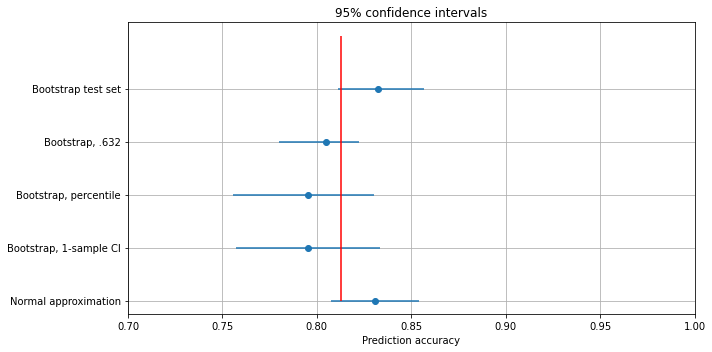

In [61]:
labels = np.array(results_df.index)

means, lower_error, upper_error = map(
    np.array,
    [results_df["acc_test"], results_df["ci_lower"], results_df["ci_upper"]]
    )

asymmetric_error = [means - lower_error, upper_error - means]

fig, ax = plt.subplots(figsize=(10, 5))
ax.errorbar(means, np.arange(len(means)), xerr=asymmetric_error, fmt="o")
ax.set_xlim([0.7, 1.0])
ax.set_yticks(np.arange(len(means)))
ax.set_yticklabels(labels)
ax.set_xlabel("Prediction accuracy")
ax.set_title("95% confidence intervals")

ax.vlines(
    acc_test_true, [0], 5, lw=1.5, color="red", linestyle="-",
    label="True value"
    )

plt.grid()
plt.tight_layout()
plt.show()

## Repeating the Synthetic Dataset Experiment 1000 Times